# Homework 3

In [5]:
%pip install -U sklearn pandas imblearn matplotlib dalex lime


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import functools

data = pd.read_csv("brain_stroke.csv")

data["ever_married"] = data["ever_married"] == "Yes"
data["urban"] = data["Residence_type"] == "Urban"
data = data.drop("Residence_type", axis=1)
data["male"] = data["gender"] == "Male"
data = data.drop("gender", axis=1)

def one_hot(data, column):
  return data.drop(column, axis=1).join(pd.get_dummies(data[column], prefix=column))

data = functools.reduce(one_hot, ["work_type", "smoking_status"], data)
data = data.rename(lambda x: x.lower(), axis=1)

data.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,urban,male,work_type_govt_job,work_type_private,work_type_self-employed,work_type_children,smoking_status_unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,True,228.69,36.6,1,True,True,0,1,0,0,0,1,0,0
1,80.0,0,1,True,105.92,32.5,1,False,True,0,1,0,0,0,0,1,0
2,49.0,0,0,True,171.23,34.4,1,True,False,0,1,0,0,0,0,0,1
3,79.0,1,0,True,174.12,24.0,1,False,False,0,0,1,0,0,0,1,0
4,81.0,0,0,True,186.21,29.0,1,True,True,0,1,0,0,0,1,0,0


# Train/test split

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.1, random_state=1)
train_X, train_y = train.drop("stroke", axis=1), train["stroke"]
test_X, test_y = test.drop("stroke", axis=1), test["stroke"]

# reset indexes
train_X, train_y = train_X.reset_index(drop=True), train_y.reset_index(drop=True)
test_X, test_y = test_X.reset_index(drop=True), test_y.reset_index(drop=True)

# Logistic regression

Applied balanced class weight due to class imbalance.

In [8]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=1).fit(train_X, train_y)

# Random forest

Similarly to previous, applied balanced class weight. Reduced max depth in order to prevent overfitting.

In [9]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(class_weight="balanced", max_depth=6, random_state=1).fit(train_X, train_y)

## 1. Calculate the predictions for some selected observations

In [10]:
sample_id = 12
observation = train_X.iloc[[sample_id]]

In [11]:
train_y.iloc[[sample_id]]

12    1
Name: stroke, dtype: int64

In [12]:
import dalex

exp = dalex.Explainer(model_rf, train_X, train_y, verbose=False)

exp.predict(observation)

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([0.67197002])


## 2. Then, calculate the decomposition of these predictions with `LIME` using the package of choice, e.g. in Python: `lime`, `dalex`, in R: `iml`, `localModel`.

In [13]:
explanation = exp.predict_surrogate(observation)
explanation.result

,variable,effect
0,age > 61.00,0.317787
1,0.00 < ever_married <= 1.00,0.072123
2,work_type_children <= 0.00,0.070944
3,hypertension <= 0.00,-0.037780
4,male <= 0.00,0.023214
5,work_type_govt_job <= 0.00,0.012469
6,0.00 < smoking_status_never smoked <= 1.00,-0.011189
7,23.70 < bmi <= 28.20,0.011115
8,0.00 < work_type_private <= 1.00,0.010609
9,heart_disease <= 0.00,0.010371


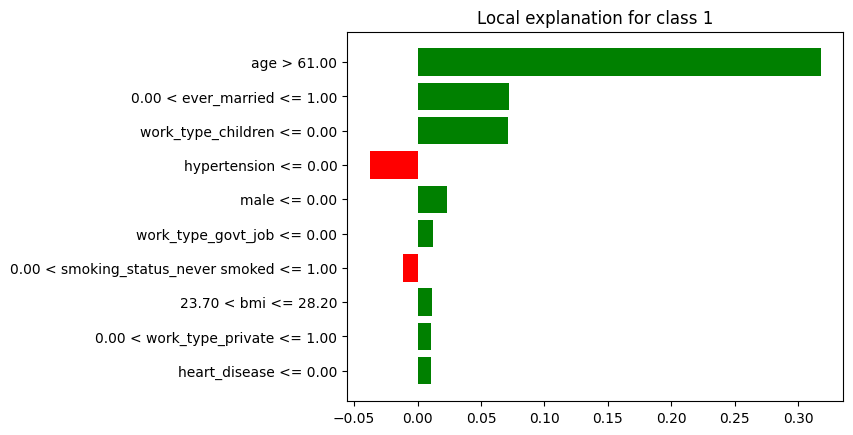

In [14]:
explanation.plot()

## 3. Compare LIME for various observations in the dataset. How stable are these explanations? 

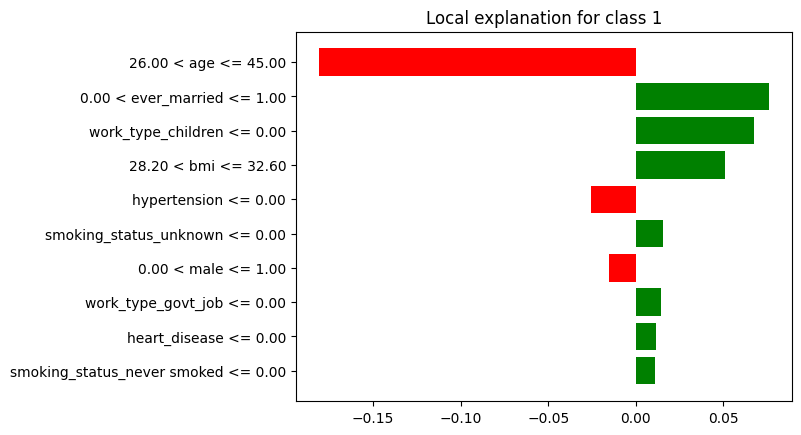

In [15]:
observation = train_X.iloc[[0]]
exp.predict_surrogate(observation, random_state=1).plot()

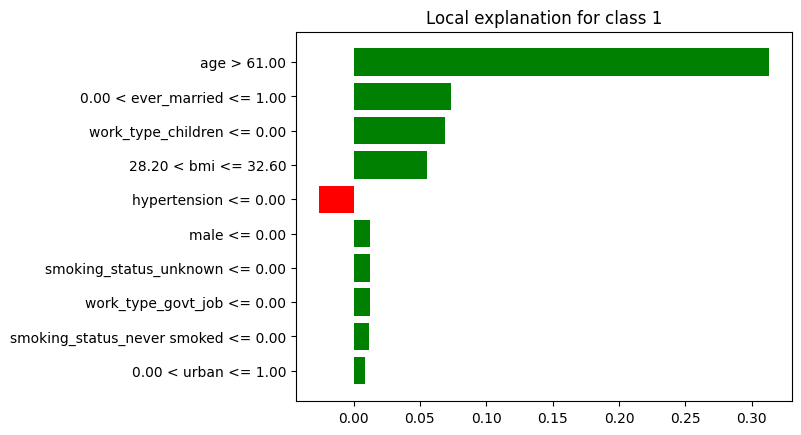

In [16]:
observation = train_X.iloc[[1]]
exp.predict_surrogate(observation, random_state=1).plot()

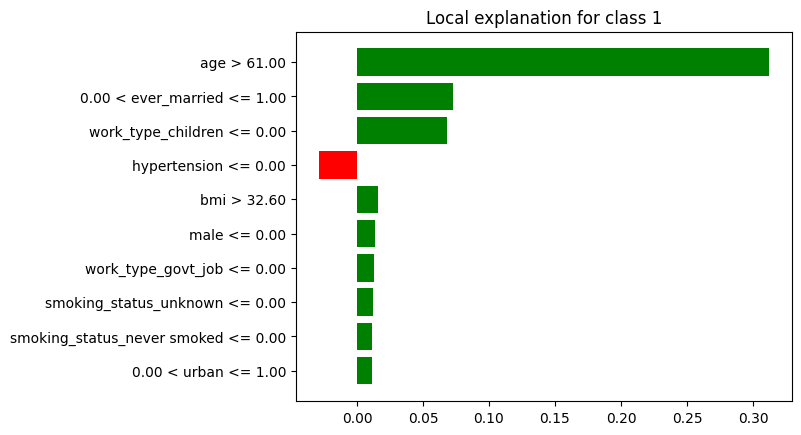

In [17]:
observation = train_X.iloc[[2]]
exp.predict_surrogate(observation, random_state=1).plot()

## 4. Compare LIME with the explanations obtained using SHAP. What are the main differences between them?

In [18]:
exp.predict_parts(observation, 'shap', N=500, random_state=1).plot()

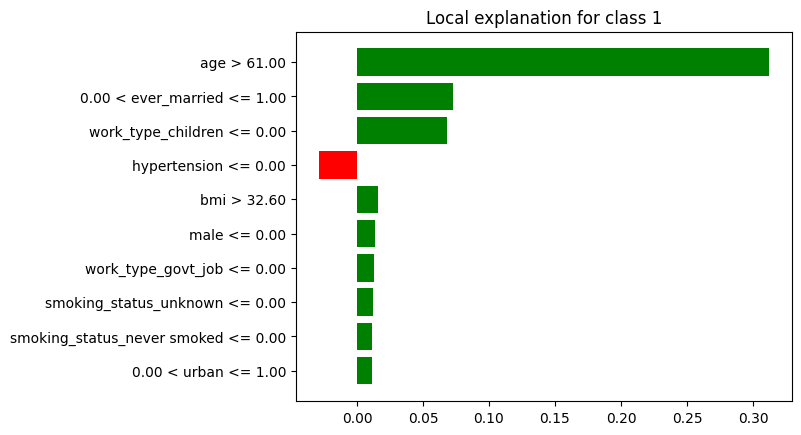

In [19]:
exp.predict_surrogate(observation, random_state=1).plot()

SHAP is more black-boxed - I can apply it to any model accepting and returning numerical values and will get an explanation of how this *exact* value of a variable contributes to the overall prediction.

LIME, on the other hand, specifies significance of features in the explainable space, which is more problem-specific (can be regions for images, word buckets for NLP or value ranges for arbitrary numerical data) and preserves less information, but presents it in a (potentially) more understandable way. Unlike SHAP, it does require some notion of *closeness* of observations.

## 5. Compare LIME between at least two different models. Are there any systematic differences across many observations?

In [20]:
exp_rf = dalex.Explainer(model_rf, train_X, train_y, verbose=False)
exp_lr = dalex.Explainer(model_lr, train_X, train_y, verbose=False)

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



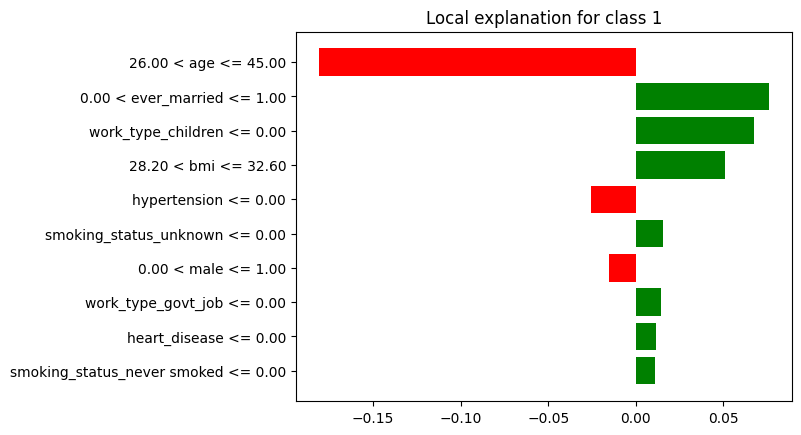

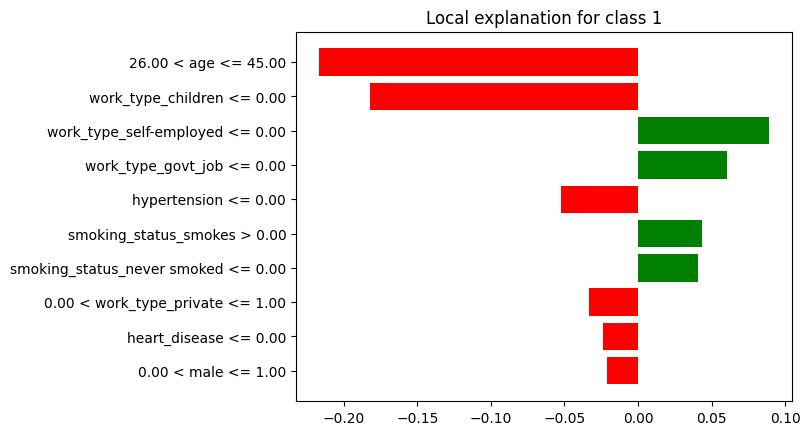

In [21]:
observation = train_X.iloc[[0]]
exp_rf.predict_surrogate(observation, random_state=1).plot()
exp_lr.predict_surrogate(observation, random_state=1).plot()

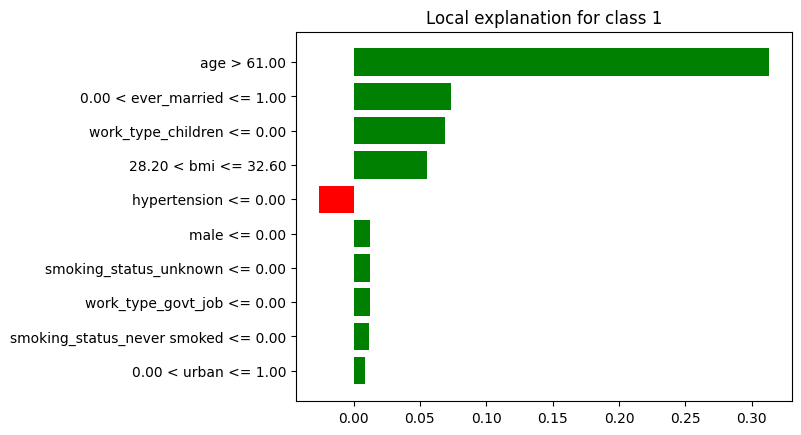

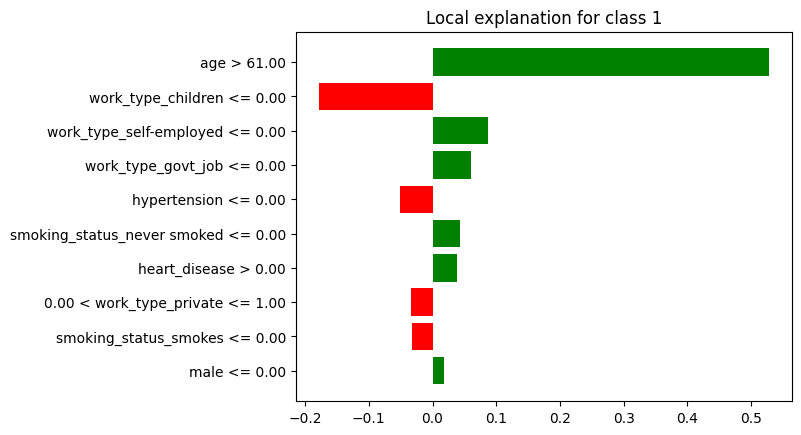

In [22]:
observation = train_X.iloc[[1]]
exp_rf.predict_surrogate(observation, random_state=1).plot()
exp_lr.predict_surrogate(observation, random_state=1).plot()

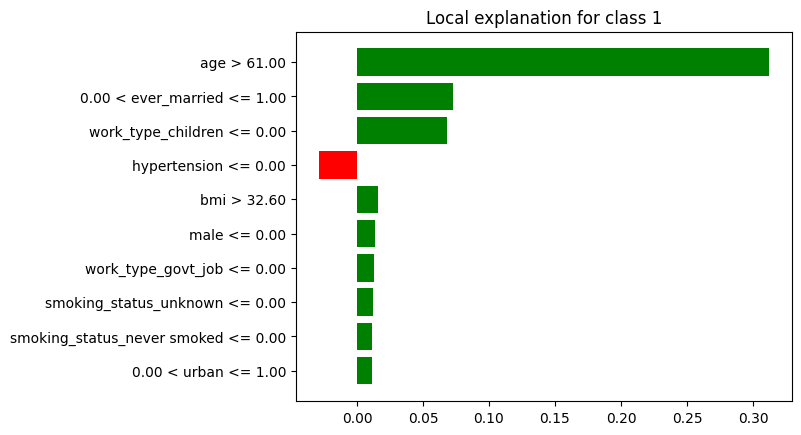

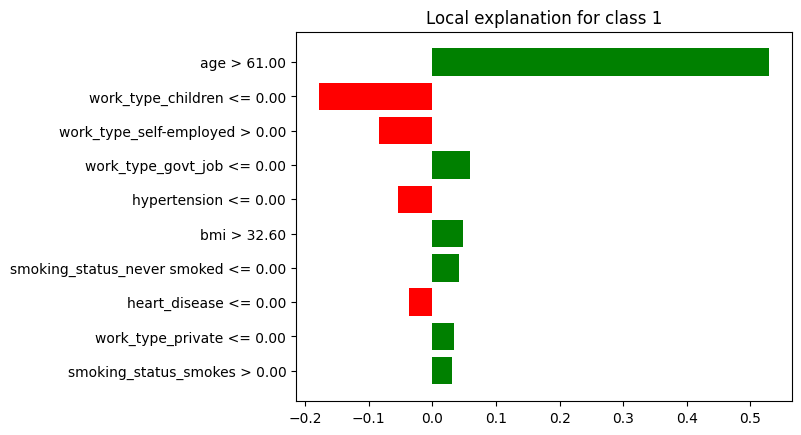

In [23]:
observation = train_X.iloc[[2]]
exp_rf.predict_surrogate(observation, random_state=1).plot()
exp_lr.predict_surrogate(observation, random_state=1).plot()

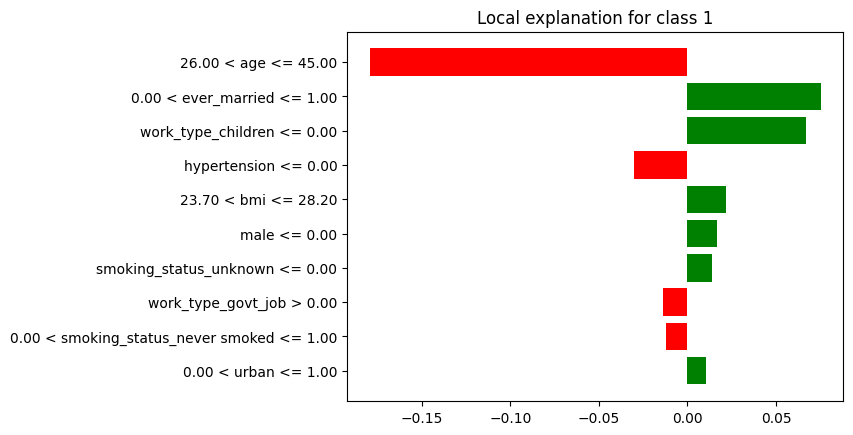

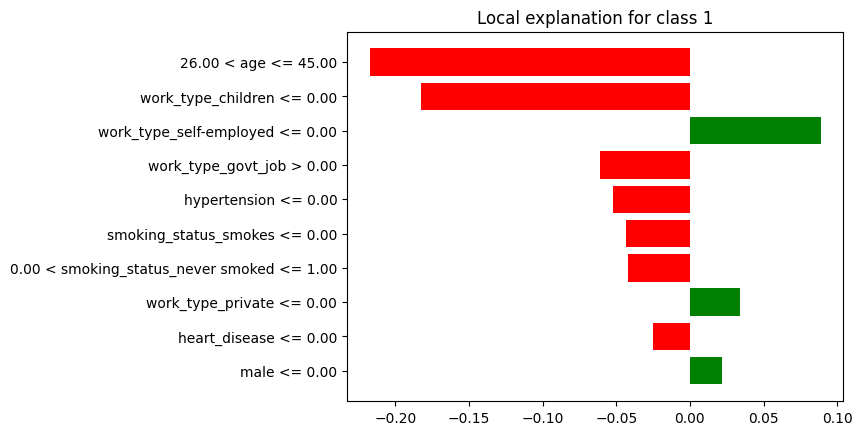

In [24]:
observation = train_X.iloc[[3]]
exp_rf.predict_surrogate(observation, random_state=1).plot()
exp_lr.predict_surrogate(observation, random_state=1).plot()

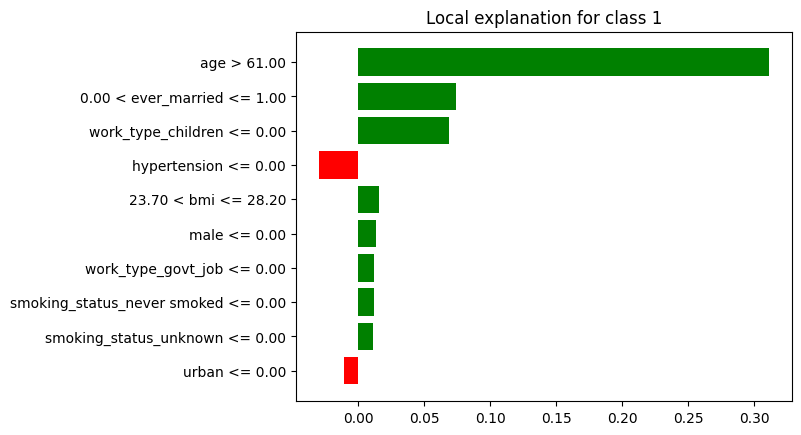

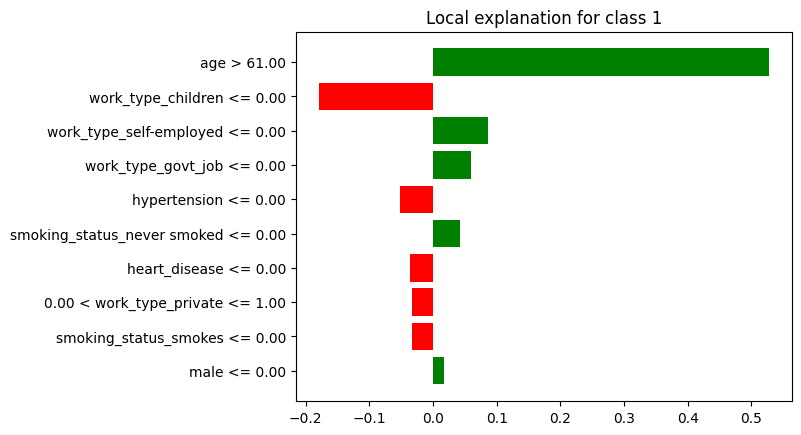

In [25]:
observation = train_X.iloc[[4]]
exp_rf.predict_surrogate(observation, random_state=1).plot()
exp_lr.predict_surrogate(observation, random_state=1).plot()